# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

In [2]:
import random

class base:
    SILENT=6
    DEBUG=1
    INFO=2
    WARNING=3
    ERROR=4
    CRITICAL=5
    
    def __init__(self,level=0):
        self.level=level
        
    def message(self,level,*args):
        if level >= self.level:
            print(*args)
            
class Card(base):
    __suits = ["Clubs", "Diamonds", "Hearts", "Spades", "ShuffleCard"]
    __values = list(range(2,11)) + [ "Jack", "Queen", "King", "Ace"]

    def __init__(self,suit,value=None):
        base.__init__(self)
        self.__suit = suit if suit in self.__suits else None
        self.__value = value if value in self.__values else None
        
        if self.__suit is None:
            self.message(self.ERROR, "Error, bad suit:",suit)

        if self.__value is None and self.__suit != "ShuffleCard":
            self.message(self.ERROR, "Error, bad value:",value)

    def value(self):
        return self.__value
    
    def suit(self):
        return self.__suit
    
    def numerical_value(self):
        # Special Handling of aces
        if self.__value == "Ace":
            return 1
        elif self.__value in [ "Jack", "Queen", "King"]:
            return 10
        else:
            return self.__value
        
    def shuffle_card(self):
        return self.__suit == "ShuffleCard"

    def __str__(self):
        if self.shuffle_card():
            return "Shuffle Card"
        else:
            return str(self.__value) + " of " + self.__suit

    __repr__ = __str__
    
class Deck(base):
    __suits = ["Clubs", "Diamonds", "Hearts", "Spades"]
    __values = list(range(2,11)) + [ "Jack", "Queen", "King", "Ace"]

    def __init__(self,n_decks=6):
        base.__init__(self)
        self.__n_decks=n_decks
        
        self.__cards = list()
        
        for _ in range(self.__n_decks):
            self.__cards.extend(self.__make_deck())            
            
        # TODO: Add logic to appropriately place shufflecard
        random_position = random.randint(0, len(self.__cards))  # Generate a random position
        self.__cards.insert(random_position, Card("ShuffleCard"))
        
    def __make_deck(self):
        deck=list()
        for suit in self.__suits:
            for value in self.__values:
                deck.append(Card(suit,value))
        return deck
    
    def shuffle(self):
        random.shuffle(self.__cards) 
        
    def deal(self):
        if len(self.__cards)>0:
            return self.__cards.pop()
        else:
            for _ in range(self.__n_decks):
                self.__cards.extend(self.__make_deck()) 
            self.shuffle()
            return self.__cards.pop()

In [3]:
my_deck = Deck()
my_deck.shuffle()

[my_deck.deal() for _ in range(10)]

[King of Hearts,
 9 of Spades,
 8 of Spades,
 5 of Clubs,
 2 of Spades,
 9 of Hearts,
 9 of Diamonds,
 Ace of Clubs,
 4 of Clubs,
 Queen of Clubs]

2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

In [4]:
import random

def calc_hand_value(hand): 
    card_values = list(map(lambda card: card.numerical_value(), hand))

    n_As = len(list(filter(lambda x: x == 1, card_values)))
    
    hand_value = sum(card_values)

    if n_As == 0:
        return hand_value
    
    # Case the last Ace is a 1
    Ace_as_one = hand_value
    Ace_as_eleven = hand_value + 10
    
    if Ace_as_eleven <= 21:
        return Ace_as_eleven
    else:
        return Ace_as_one

class PlayerBase(base):
    def __init__(self, name, n_chips):
        base.__init__(self)
        self.__name = name
        self.__n_chips = n_chips
    
    def name(self):
        return self.__name
    
    def chips(self):
        return self.__n_chips
    
    def pay(self, value=2):
        self.__n_chips += value

    def deduct(self, value=2):
        # Deducting chips and checking if chips are negative
        if self.__n_chips - value >= 0:
            self.__n_chips -= value
        else:
            self.__n_chips = 0  # Preventing negative chip count
    
    def play_hand(self, down_card, up_cards, seen_cards):
        raise NotImplementedError
        
    def __str__(self):
        return self.__name + " (" + str(self.__n_chips) + ")"
    
    __repr__ = __str__
    
class DealerPlayer(PlayerBase):
    def __init__(self, threshold=16):
        self.__threshold = threshold
        PlayerBase.__init__(self, "Mr. Dealer", 1000)

    def play_hand(self, down_card, up_cards, seen_cards):
        # Dealer's strategy: hit on 16 or less, stay on 17 or more
        hand_value = calc_hand_value([down_card] + up_cards)
        return hand_value < self.__threshold
    
class ConsolePlayer(PlayerBase):
    def play_hand(self, down_card, up_cards, seen_cards):
        print("Down Card:", down_card)
        print("Up Cards:", up_cards)
        print("Seen Cards:", seen_cards)
        hit_str = input("Hit(Y/N):")
        return hit_str.upper() == "Y"

class Strategy_1_Player(PlayerBase):
    def play_hand(self, down_card, up_cards, seen_cards):
        # Example of a simple strategy: always hit
        return True

class Game(base):
    def __init__(self, n_decks=6):
        base.__init__(self, self.INFO)
        self.__n_decks = n_decks
        self.__players = list()
        self.__all_players = list()
        self.__shuffle = False
    
    def players(self):
        return self.__players
    
    def all_players(self):
        return self.__all_players

    def add_player(self, player):
        self.__players.append(player)
        self.__all_players.append(player)

    def deal_and_check_shuffle(self, deck):
        card = deck.deal()
        if card.shuffle_card():
            shuffle = True
            card = deck.deal()
        return card
    
    def show_status(self, hands, seen_cards):
        self.message(self.INFO, "----------------------------------------------------------------")
        self.message(self.INFO, "Hands:", hands)
        self.message(self.INFO, "Seen Cards:", seen_cards)
        self.message(self.INFO, "*************************************************")
        self.message(self.INFO, "Players:")
        self.message(self.INFO, "*************************************************")
        for i, player in enumerate(self.__all_players):
            self.message(self.INFO, i, ":", player)
        self.message(self.INFO, "----------------------------------------------------------------")

    def play_game(self, n_hands):
        # Create Dealer
        self.add_player(DealerPlayer())
        
        deck = None
        self.__shuffle = False
        
        # Check if all players have chips to play
        self.__players = list(filter(lambda player: player.chips() >= 2, self.__players))
        
        if len(self.__players) == 0:
            self.message(self.DEBUG, "No players with enough chips to play.")
            return
        
        for i_hand in range(n_hands):
            self.message(self.DEBUG, "n players, n all players", len(self.__players), len(self.__all_players))            
            self.message(self.DEBUG, "Starting Hand:", i_hand, "/", n_hands)
            
            # Do we have a deck or have to shuffle?
            if deck is None or self.__shuffle:
                self.message(self.DEBUG, "Creating New Deck / Shuffling")
                deck = Deck()
                deck.shuffle()
                seen_cards = list()
                self.__shuffle = False

            hands = list()

            # Deal Each Player's Hand
            # Down card deal
            self.message(self.DEBUG, "Dealing Cards")
            for player_i, player in enumerate(self.__players):
                down_card = self.deal_and_check_shuffle(deck)
                up_cards = list()
                hands.append((down_card, up_cards))
                if player_i < len(self.__players) - 1:
                    seen_cards.append(down_card)

            # Up card deal
            for (down_card, up_cards) in hands:
                up_cards.append(self.deal_and_check_shuffle(deck))                
                seen_cards.append(up_cards[-1])
                
            # Show hands and status
            self.show_status(hands, seen_cards)
            
            # Deal cards and ask players to hit/stay
            for player_i, ((down_card, up_cards), player) in enumerate(zip(hands, self.__players)):
                self.message(self.DEBUG, "Asking Player", player_i, "to Play")
                self.message(self.DEBUG, "Player", player_i, "hand total:", calc_hand_value([down_card] + up_cards))
                hit = True
                this_hand_up_cards = list()
                
                while hit:
                    hit = player.play_hand(down_card, up_cards, seen_cards)

                    if hit:
                        self.message(self.DEBUG, "Player", player_i, "Hit")
                        card = self.deal_and_check_shuffle(deck)
                        up_cards.append(card)
                        this_hand_up_cards.append(card)
                        hand_value = calc_hand_value([down_card] + up_cards)
                        self.message(self.DEBUG, "Hand Value:", hand_value)
                        if hand_value < 21:
                            hit = True
                        else: 
                            hit = False
                            if hand_value > 21:
                                self.message(self.DEBUG, "Player", player_i, "Busted")     
                            else:
                                self.message(self.DEBUG, "Player", player_i, "Got 21")
                    else:
                        self.message(self.DEBUG, "Player", player_i, "Stay")

                seen_cards.append(down_card)
                seen_cards.extend(this_hand_up_cards)

            # Pay based on hand values
            hand_values = [calc_hand_value([hand[0]] + hand[1]) for hand in hands]
            self.message(self.DEBUG, "Hand Values", hand_values)
            
            # Determine who gets paid
            if hand_values[-1]==21:
                self.message(self.DEBUG,"Dealer Got 21")
                for player_i,(hand_value,player) in enumerate(zip(hand_values[:-1],self.__players[:-1])):
                    if hand_value==21:
                        self.message(self.DEBUG,"Player",player_i,"Got 21. Paying 3 chips.")
                        player.pay(3)
                    else:
                        self.message(self.DEBUG,"Player",player_i,"Busted or dealer won. Deducting 2 chips.")
                        player.deduct(2)
                    
            if hand_values[-1]>21:        
                self.message(self.DEBUG,"Dealer Busted")
                for player_i,(hand_value,player) in enumerate(zip(hand_values[:-1],self.__players[:-1])):
                    if hand_value==21:
                        self.message(self.DEBUG,"Player",player_i,"Got 21. Paying 3 chips.")
                        player.pay(3)
                    elif hand_value>21:
                        self.message(self.DEBUG,"Player",player_i,"Busted. Deducting 2 chips.")
                        player.deduct(2)
                    else:
                        self.message(self.DEBUG,"Player",player_i,"Paying 2 chips.")
                        player.pay(2)
                        
            if hand_values[-1]<21:
                self.message(self.DEBUG,"Dealer hand is:",hand_values[-1])
                for player_i,(hand_value,player) in enumerate(zip(hand_values[:-1],self.__players[:-1])):
                    if hand_value==21:
                        self.message(self.DEBUG,"Player",player_i,"Got 21. Paying 3 chips.")
                        player.pay(3)
                    elif hand_value>21:
                        self.message(self.DEBUG,"Player",player_i,"Busted. Deducting 2 chips.")
                        player.deduct(2)
                    elif hand_value >  hand_values[-1]:
                        self.message(self.DEBUG,"Player",player_i," hand was",hand_value, "versus Dealer hand",
                                     hand_values[-1],"Paying 2 chips.")
                        player.pay(2)
                    else:
                        self.message(self.DEBUG,"Player",player_i," hand was",hand_value, "versus Dealer hand",
                                     hand_values[-1],"Deducting 2 chips.")
                        player.deduct(2)


5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

In [17]:
my_game=Game()
my_game.level=Game.DEBUG

my_game.add_player(Strategy_1_Player("Dummy player",100))
my_game.add_player(ConsolePlayer("ME!",100))

my_game.play_game(2)

n players, n all players 3 3
Starting Hand: 0 / 2
Creating New Deck / Shuffling
Dealing Cards
----------------------------------------------------------------
Hands: [(Ace of Diamonds, [8 of Hearts]), (3 of Spades, [8 of Spades]), (5 of Hearts, [Queen of Diamonds])]
Seen Cards: [Ace of Diamonds, 3 of Spades, 8 of Hearts, 8 of Spades, Queen of Diamonds]
*************************************************
Players:
*************************************************
0 : Dummy player (100)
1 : ME! (100)
2 : Mr. Dealer (1000)
----------------------------------------------------------------
Asking Player 0 to Play
Player 0 hand total: 19
Player 0 Hit
Hand Value: 21
Player 0 Got 21
Asking Player 1 to Play
Player 1 hand total: 11
Down Card: 3 of Spades
Up Cards: [8 of Spades]
Seen Cards: [Ace of Diamonds, 3 of Spades, 8 of Hearts, 8 of Spades, Queen of Diamonds, Ace of Diamonds, 2 of Diamonds]
Hit(Y/N):y
Player 1 Hit
Hand Value: 16
Down Card: 3 of Spades
Up Cards: [8 of Spades, 5 of Diamonds]
Seen

6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

In [23]:
class Strategy_1_Player(PlayerBase):
    def play_hand(self, down_card, up_cards, seen_cards ):
        return True

class Strategy_2_Player(PlayerBase):
    def __init__(self, name, n_chips, threshold=-300):
        super().__init__(name, n_chips)
        self.threshold = threshold
        self.running_count = 0

    def card_value(self, card):
        if card.numerical_value() >= 2 and card.numerical_value() <= 6:
            return 1
        elif card.numerical_value() >= 7 and card.numerical_value() <= 9:
            return 0
        else:
            return -1

    def update_running_count(self, cards):
        for card in cards:
            self.running_count += self.card_value(card)

    def play_hand(self, down_card, up_cards, seen_cards):
        # Update the running count based on all the cards seen (including down and up cards)
        self.update_running_count(seen_cards)

        # Player strategy: hit if running count is less than the threshold, otherwise stay
        if self.running_count <= self.threshold:
            return True  # Hit if the running count is very negative (below threshold)
        else:
            return False  # Stay if the running count is positive (above threshold)

class DealerLikePlayer(PlayerBase):
    def __init__(self,name,chips,threshold=16):
        self.__threshold = threshold
        PlayerBase.__init__(self,name, chips)

    def play_hand(self, down_card, up_cards, seen_cards ):
        hand_value = calc_hand_value([down_card] + up_cards)
        return hand_value < self.__threshold

7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

In [18]:
my_game=Game()
my_game.level=Game.SILENT

my_game.add_player(Strategy_2_Player("Strategy 2 player",100))
my_game.add_player(DealerLikePlayer("Stays on 13",100,13))
my_game.add_player(DealerLikePlayer("Stays on 16",100,16))
my_game.add_player(DealerLikePlayer("Stays on 20",100,20))

my_game.play_game(50)
[player.chips() for player in my_game.players()]

[92, 82, 78, 80, 1000]

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


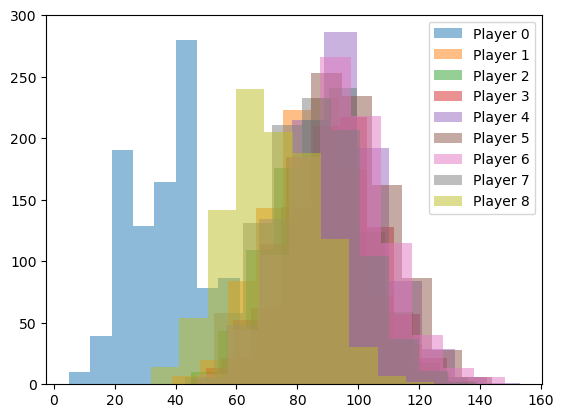

In [29]:
def play_many_rounds(n_rounds=100,n_hands=50):
    
    results = list()
    
    for i_round in range(n_rounds):
        results.append(play_a_round(n_hands))
        
    return results
results= play_many_rounds(1000)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
res = np.array(results)
res = res [:,:-1]
for i in range(res.shape[1]):
    plt.hist(res[:,i],label="Player "+str(i),alpha=0.5)
    
plt.legend()
plt.show()

9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

In [42]:
my_game=Game()
my_game.level=Game.SILENT

my_game.add_player(Strategy_2_Player("Threshold 0",100,300))
my_game.add_player(Strategy_2_Player("Threshold -10",100,100))
my_game.add_player(Strategy_2_Player("Threshold -50",100,0))
my_game.add_player(Strategy_2_Player("Threshold -100",100,-100))
my_game.add_player(Strategy_2_Player("Threshold -200",100,-300))


my_game.play_game(50)
[player.chips() for player in my_game.players()]

[35, 40, 69, 60, 112, 1000]

ANSWER: The lower the threshold the more optimal

10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

In [52]:
class New_Strategy_Player(PlayerBase):
    def play_hand(self, down_card, up_cards, seen_cards):
        hand_value = calc_hand_value([down_card] + up_cards)
        
        if hand_value >= 17:
            return False
        
        if hand_value < 12:
            return True
        
        dealer_upcard_value = up_cards[0].numerical_value() 
        if dealer_upcard_value >= 2 and dealer_upcard_value <= 6:
            return False

        return True
    
my_game=Game()
my_game.level=Game.SILENT

my_game.add_player(New_Strategy_Player("New Strat",100))
my_game.add_player(Strategy_2_Player("Threshold -10",100,100))
my_game.add_player(Strategy_2_Player("Threshold -50",100,0))
my_game.add_player(Strategy_2_Player("Threshold -100",100,-100))
my_game.add_player(Strategy_2_Player("Threshold -200",100,-300))


my_game.play_game(50)
[player.chips() for player in my_game.players()]


[116, 73, 55, 75, 72, 1000]

ANSWER: Each number in the array indicates the number of chips. The first number in the array is the new strategy player and the results indicate that they perform the best.